In [1]:
# Libraries 
import os
import torch
import argparse
import torchvision
import numpy as np
from glob import glob
import torch.utils.data
from torch import nn, optim
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline

#Set reproducibility seeed
torch.manual_seed(1)

In [25]:
class VSC(nn.Module):
    def __init__(self, latent):
        super(VSC, self).__init__()
        self.c = 200.0 
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, latent )
        self.fc22 = nn.Linear(400, latent)
        self.fc23 = nn.Linear(400, latent)
        self.fc3 = nn.Linear(latent, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        #Recognition function
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1), -F.relu(-self.fc23(h1))

    def reparameterize(self, mu, logvar, logspike ):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        gaussian = eps.mul(std).add_(mu)
        eta = torch.rand_like(std)
        selection = F.sigmoid(self.c*(eta + logspike.exp() - 1))
        return selection.mul(gaussian)

    def decode(self, z):
        #Likelihood function
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar, logspike = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar, logspike)
        return self.decode(z), mu, logvar, logspike
    

In [36]:
#vsc_mnist_models_05 = []
#for i in range(8,201,8):
#    vsc_mnist_models_05.append( VSC(i))
#    vsc_mnist_models_05[-1].load_state_dict(torch.load('../src/models/vsc_mnist_1_11_' + str(i) + '_0-001_0.5_11_.pth'))
    
#vsc_mnist_model = vsc_mnist_models_05[0]
vsc_mnist_model = VSC(200)
vsc_mnist_model.load_state_dict(torch.load('../src/models/vsc_mnist_1_11_200_0-001_0.5_11_.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

    5     1     4     2     6     9     7     9     3     9     7     8     7     3     0     2


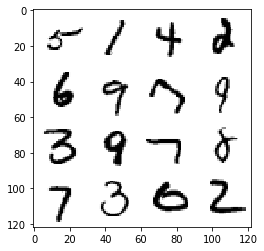

In [37]:

BATCH_SIZE = 32

### MNIST 
mnist_train_loader = torch.utils.data.DataLoader(
                        datasets.MNIST('../data/mnist', train=True, transform=transforms.ToTensor()),
                        batch_size=BATCH_SIZE, shuffle=False, sampler=SubsetRandomSampler(np.random.permutation(60000)[:5000]) )

dataiter = iter(mnist_train_loader)
mnist_images, mnist_labels = dataiter.next()


def imshow(img):
    npimg = 1 - img.numpy() # White background
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation = 'nearest')

# Display images with labels
imshow(torchvision.utils.make_grid(mnist_images[:16], 4 ))
print(' '.join('%5s' % str(mnist_labels[j].item()) for j in range(16)))


In [38]:
# Plot the z encoding 
def plot_encoding ( example_image , model , alpha , width = 1/2 ):
    
    decoded , mu, logvar,logspike  = model.forward( example_image )
    z = model.reparameterize( mu , logvar , logspike  )
    
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols = 3 , figsize=(21,7) )
    
    img =  torchvision.utils.make_grid( example_image ) 
    npimg = 1 - img.detach().numpy() # White background
    ax0.imshow(np.transpose(npimg, (1, 2, 0)), interpolation = 'nearest')
    ax0.set_title('Input Image', fontsize = 20 )
    
    ax1.bar( np.arange(z.shape[1]) , height = z.detach().numpy()[0] , width = width, align = 'center'  )
    ax1.scatter(  np.arange(z.shape[1]) , z.detach().numpy()[0], color = 'blue' )
    ax1.set_title(r"Latent Dimension %d - $\alpha$ = %.2f "%(z.shape[1], alpha) , fontsize = 20)
    
    img =  torchvision.utils.make_grid( model.decode( z ).view(1,1,28,28) ) 
    npimg = 1 - img.detach().numpy() # White background
    ax2.imshow(np.transpose(npimg, (1, 2, 0)), interpolation = 'nearest')
    ax2.set_title('Decoded Image', fontsize = 20 )

    plt.subplots_adjust(hspace=0.5)

torch.Size([32, 1, 28, 28])
torch.Size([1, 28, 28])


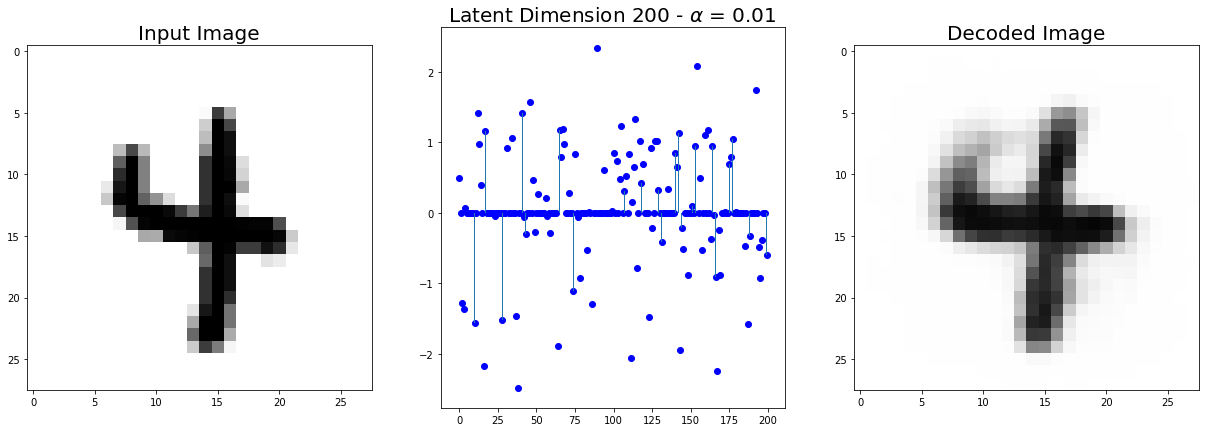

In [40]:
print(mnist_images.size())
print(mnist_images[2].size())
plot_encoding( mnist_images[2] , vsc_mnist_model, 0.01, width = 1/7  )
#plot_encoding( mnist_images[2] , vsc_mnist_models_05[11], 0.01 )
#plot_encoding( mnist_images[2] , vsc_mnist_models_05[-1], 0.01 )

interactive(children=(FloatSlider(value=0.0, description='x0', max=3.0, min=-3.0, step=0.5), FloatSlider(value…

<function __main__.plot_result(x0, x1, x2, x3, x4, x5, x6, x7)>

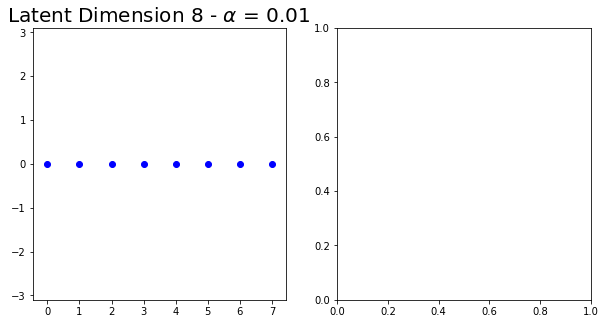

In [43]:
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider
import ipywidgets as widgets


def plot_result( x0, x1, x2, x3, x4, x5, x6, x7):
    
    z = torch.from_numpy(np.asarray([x0,x1,x2,x3,x4,x5,x6,x7])).view(1,-1)
    z = z.type(torch.FloatTensor)
    
    fig, ax = plt.subplots(nrows=1, ncols = 2 , figsize=(10,5 ) )
    
    #Plot encodings
    ax[0].bar( np.arange(z.shape[1]) , height = z.detach().numpy()[0] , width = 1/7  )
    ax[0].scatter(  np.arange(z.shape[1]) , z.detach().numpy()[0], color = 'blue' )
    ax[0].set_title(r"Latent Dimension %d - $\alpha$ = %.2f "%(z.shape[1], 0.01) , fontsize = 20)
    ax[0].set_ylim(-3.1, 3.1)
    
    #Plot decoded images
    img =  torchvision.utils.make_grid( vsc_mnist_model.decode( z ).view(1,1,28,28) ) 
    npimg = 1 - img.detach().numpy() # White background
    ax[1].imshow(np.transpose(npimg, (1, 2, 0)), interpolation = 'nearest')
    ax[1].set_title('Decoded Image', fontsize = 20 )
    

interact(plot_result ,
                x0 = FloatSlider(min=-3.0, max=3.0, step=0.5) , 
                x1 = FloatSlider(min=-3.0, max=3.0, step=0.5) , 
                x2 = FloatSlider(min=-3.0, max=3.0, step=0.5) , 
                x3 = FloatSlider(min=-3.0, max=3.0, step=0.5) , 
                x4 = FloatSlider(min=-3.0, max=3.0, step=0.5) , 
                x5 = FloatSlider(min=-3.0, max=3.0, step=0.5) , 
                x6 = FloatSlider(min=-3.0, max=3.0, step=0.5) , 
                x7 = FloatSlider(min=-3.0, max=3.0, step=0.5) )

In [47]:
def vsc_conditional_sampling ( example_image , model , length = 6, percentage = 0.8 ):
    
    decoded , mu, logvar,logspike  = model.forward( example_image )
    z = model.reparameterize( mu , logvar , logspike  )
    
    plt.figure(figsize = (2,2))
    plt.axis('off')
    img = torchvision.utils.make_grid( example_image.view(1,1,28,28)).numpy()
    
    plt.imshow(np.transpose(1-img,(1,2,0)))
    plt.show()

    # Non zero elements
    non_zero = []
    for i in range(z.shape[1]):
        if np.abs(z[0,i].detach().numpy()) > 1e-4:
            non_zero.append(i)

    # Pick a set of random non zero coordinates of percentage of the activated dimensions
    ind = np.random.choice(non_zero, int(percentage * len(non_zero) ) )

    # Produce result images
    images = []
    for _ in range(length):
    
        # Obtain samples for each activated dimension
        z1 = z.clone()
        for i in ind:
            z1[0,i] = np.random.normal() # Prior Gasussian Components
            
        img =  torchvision.utils.make_grid( model.decode( z1 ).view(1,1,28,28) ) 
        npimg = 1 - img.detach().numpy() # White background
        images.append(np.transpose(npimg, (1, 2, 0)))
        
    traversal = np.concatenate(images, axis = 1 )
    
    plt.figure(figsize = (14,10))
    plt.axis('off')
    plt.imshow(traversal)
    plt.show()
    
    return traversal

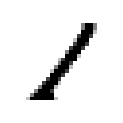

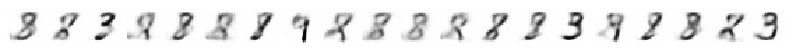

In [48]:
vsc_mnist_models_05 = VSC(200)
vsc_mnist_models_05.load_state_dict(torch.load('../src/models/vsc_mnist_1_11_200_0-001_0.5_11_.pth'))
digit = vsc_conditional_sampling( mnist_images[21] , vsc_mnist_models_05, length=20)